# 使い方のチェックを行う
https://github.com/Mishima-syk/py4chemoinformatics/blob/master/py4c.asciidoc#chembl

バイオインフォマティクスに関するデータ処理の手法についての本。

目指せマスター

In [ ]:
import numpy as np 
import pandas as pd 

In [ ]:
import torch
import torchvision

#### 単にSMILES形式のデータを視覚化する

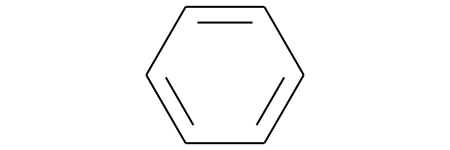

In [ ]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
# SMILES形式のデータを読み込む
mol = Chem.MolFromSmiles("c1ccccc1")
mol

#### 一部を変化させた化合物の順挙
化合物は一部を変化させただけでも、性質が変化する。
一部を変化させることをヘテロシャッフルと呼ぶ
一部を変化させる方法を確かめるとともに、それを列挙する。

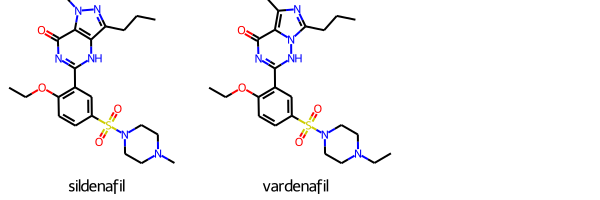

In [2]:
# わずかな構造の差が性能に変化を与える例がこの二つである
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor
from rdkit.Chem import rdFMCS
from rdkit.Chem import TemplateAlign
IPythonConsole.ipython_useSVG = True
rdDepictor.SetPreferCoordGen(True)

sildenafil = Chem.MolFromSmiles('CCCC1=NN(C)C2=C1NC(=NC2=O)C1=C(OCC)C=CC(=C1)S(=O)(=O)N1CCN(C)CC1')
vardenafil = Chem.MolFromSmiles('CCCC1=NC(C)=C2N1NC(=NC2=O)C1=C(OCC)C=CC(=C1)S(=O)(=O)N1CCN(CC)CC1')
rdDepictor.Compute2DCoords(sildenafil)
rdDepictor.Compute2DCoords(vardenafil)
res = rdFMCS.FindMCS([sildenafil, vardenafil], completeRingsOnly=True, atomCompare=rdFMCS.AtomCompare.CompareAny)
MCS = Chem.MolFromSmarts(res.smartsString)
rdDepictor.Compute2DCoords(MCS)

TemplateAlign.AlignMolToTemplate2D(sildenafil, MCS)
TemplateAlign.AlignMolToTemplate2D(vardenafil, MCS)
Draw.MolsToGridImage([sildenafil, vardenafil], legends=['sildenafil', 'vardenafil'])

### 下のコードは動かない

In [2]:
import copy
import itertools

from rdkit import Chem
from rdkit.Chem import AllChem


class HeteroShuffle():

    def __init__(self, mol, query):
        self.mol = mol
        self.query = query
        self.subs = Chem.ReplaceCore(self.mol, self.query)
        self.core = Chem.ReplaceSidechains(self.mol, self.query)
        self.target_atomic_nums = [6, 7, 8, 16]

    def make_connectors(self):
        n = len(Chem.MolToSmiles(self.subs).split('.'))
        map_no = n+1
        self.rxn_dict = {}
        for i in range(n):
            self.rxn_dict[i+1] = AllChem.ReactionFromSmarts('[{0}*][*:{1}].[{0}*][*:{2}]>>[*:{1}][*:{2}]'.format(i+1, map_no, map_no+1))
        return self.rxn_dict

    def re_construct_mol(self, core):
        '''
        re construct mols from given substructures and core
        '''
        keys = self.rxn_dict.keys()
        ps = [[core]]
        for key in keys:
            ps = self.rxn_dict[key].RunReactants([ps[0][0], self.subs])
        mol = ps[0][0]
        try:
            smi = Chem.MolToSmiles(mol)
            mol = Chem.MolFromSmiles(smi)
            Chem.SanitizeMol(mol)
            return mol
        except:
            return None

    def get_target_atoms(self):
        '''
        get target atoms for replace
        target atoms means atoms which don't have anyatom(*) in neighbors
        '''
        atoms = []
        for atom in self.core.GetAromaticAtoms():
            neighbors = [a.GetSymbol() for a in atom.GetNeighbors()]
            if '*' not in neighbors and atom.GetSymbol() != '*':
                atoms.append(atom)
        print(len(atoms))
        return atoms

    def generate_mols(self):
        atoms = self.get_target_atoms()
        idxs = [atom.GetIdx() for atom in atoms]
        combinations = itertools.product(self.target_atomic_nums, repeat=len(idxs))
        smiles_set = set()
        self.make_connectors()
        for combination in combinations:
            target = copy.deepcopy(self.core)
            for i, idx in enumerate(idxs):
                target.GetAtomWithIdx(idx).SetAtomicNum(combination[i])
            smi = Chem.MolToSmiles(target)
            target = Chem.MolFromSmiles(smi)
            if target is not None:
                n_attachment = len([atom for atom in target.GetAtoms() if atom.GetAtomicNum() == 0])
                n_aromatic_atoms = len(list(target.GetAromaticAtoms()))
                if target.GetNumAtoms() - n_attachment == n_aromatic_atoms:
                    try:
                        mol = self.re_construct_mol(target)
                        if check_mol(mol):
                            smiles_set.add(Chem.MolToSmiles(mol))
                    except:
                        pass
        mols = [Chem.MolFromSmiles(smi) for smi in smiles_set]
        return mols

In [6]:
def check_mol(mol):
    arom_atoms = mol.GetAromaticAtoms()
    symbols = [atom.GetSymbol() for atom in arom_atoms if not atom.IsInRingSize(5)]
    if not symbols:
        return True
    elif 'O' in symbols or 'S' in symbols:
        return False
    else:
        return True

In [7]:
# Gefitinib
mol1 = Chem.MolFromSmiles('COC1=C(C=C2C(=C1)N=CN=C2NC3=CC(=C(C=C3)F)Cl)OCCCN4CCOCC4')
core1 = Chem.MolFromSmiles('c1ccc2c(c1)cncn2')
#  Oxaprozin
mol2 = Chem.MolFromSmiles('OC(=O)CCC1=NC(=C(O1)C1=CC=CC=C1)C1=CC=CC=C1')
core2 =  Chem.MolFromSmiles('c1cnco1')

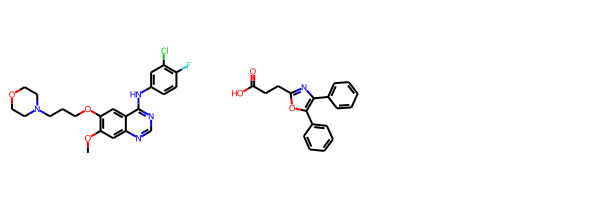

In [8]:
Draw.MolsToGridImage([mol1,mol2])

In [ ]:
# ht = HeteroShuffle(mol1, core1)
# res = ht.generate_mols()
# print(len(res))
# Draw.MolsToGridImage(res, molsPerRow=5)

In [ ]:
# ht = HeteroShuffle(mol2, core2)
# res = ht.generate_mols()
# print(len(res))
# Draw.MolsToGridImage(res, molsPerRow=5)

### ヘテロシャッフルについては、EnumerateHeterocycleというメソッドで容易に実装可能
どこをコアとして持つかについても知る必要がありそう

384


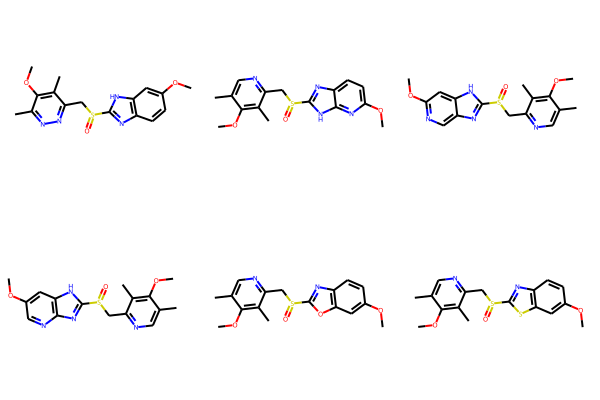

In [1]:
# EnumerateHeterocyclesはジェネレーターを返します。これは組み合わせが多くリストで返すとメモリを多く消費するためです。以下の例ではわかりやすくするためリストに変換しています。
from rdkit import Chem
from rdkit.Chem import EnumerateHeterocycles
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
import copy
omeprazole = Chem.MolFromSmiles('CC1=CN=C(C(=C1OC)C)CS(=O)C2=NC3=C(N2)C=C(C=C3)OC')
enumerated_mols = EnumerateHeterocycles.EnumerateHeterocycles(omeprazole)
enumerated_mols = [m for m in enumerated_mols]
print(len(enumerated_mols))
# 384
Draw.MolsToGridImage(enumerated_mols[:6], molsPerRow=3)

4


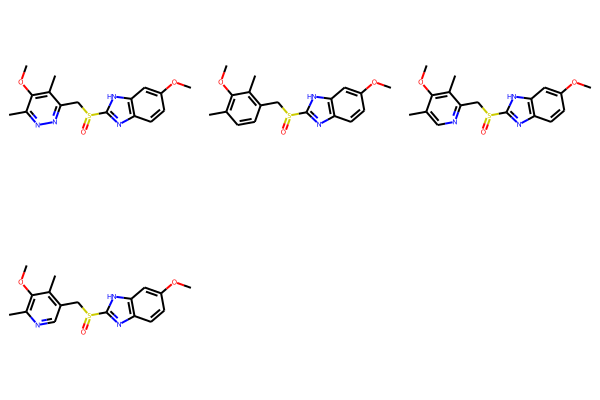

In [3]:
# 今度は56縮環部分は保護してみます。
ringinfo = omeprazole.GetRingInfo()
ringinfo.AtomRings()
# ((1, 6, 5, 4, 3, 2), (14, 13, 17, 16, 15), (18, 19, 20, 21, 15, 16))
protected_omeprazole = copy.deepcopy(omeprazole)
for idx in ringinfo.AtomRings()[1]:
    atom = protected_omeprazole.GetAtomWithIdx(idx)
    atom.SetProp("_protected", "1")
for idx in ringinfo.AtomRings()[2]:
    atom = protected_omeprazole.GetAtomWithIdx(idx)
    atom.SetProp("_protected", "1")
enumerated_mols2 = EnumerateHeterocycles.EnumerateHeterocycles(protected_omeprazole)
enumerated_mols2 = [m for m in enumerated_mols2]
print(len(enumerated_mols2))
# 4
Draw.MolsToGridImage(enumerated_mols2)

### 類似度についての検討
ベクトルに変化して、コサイン類似度とかで評価が一般的？

→ タニモト係数で評価している

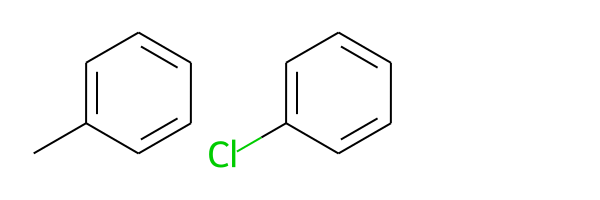

In [18]:
# トルエンとクロロベンゼンの類似度に対して評価
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole

mol1 = Chem.MolFromSmiles("Cc1ccccc1")
mol2 = Chem.MolFromSmiles("Clc1ccccc1")

Draw.MolsToGridImage([mol1, mol2])

In [5]:
fp1 = AllChem.GetMorganFingerprint(mol1, 2)
fp2 = AllChem.GetMorganFingerprint(mol2, 2)

In [6]:
DataStructs.TanimotoSimilarity(fp1, fp2)
# 0.5384615384615384

0.5384615384615384

# ヴァーチャルスクリーニング

In [8]:
# ZINCのデータセットのダウンロード
# !wget http://files.docking.org/2D/EA/EAED.smi

In [3]:
spl = Chem.rdmolfiles.SmilesMolSupplier("EAED.smi")
len(spl)

115127

In [4]:
laninamivir = Chem.MolFromSmiles("CO[C@H]([C@H](O)CO)[C@@H]1OC(=C[C@H](NC(=N)N)[C@H]1NC(=O)C)C(=O)O")
laninamivir_fp = AllChem.GetMorganFingerprint(laninamivir, 2)

def calc_laninamivir_similarity(mol):
    fp = AllChem.GetMorganFingerprint(mol, 2)
    sim = DataStructs.TanimotoSimilarity(laninamivir_fp, fp)
    return sim

In [11]:
similar_mols = []
for mol in spl:
    sim = calc_laninamivir_similarity(mol)
    if sim > 0.2:
        similar_mols.append((mol, sim))

In [12]:
similar_mols.sort(key=lambda x: x[1], reverse=True)
mols = [l[0] for l in similar_mols[:10]]

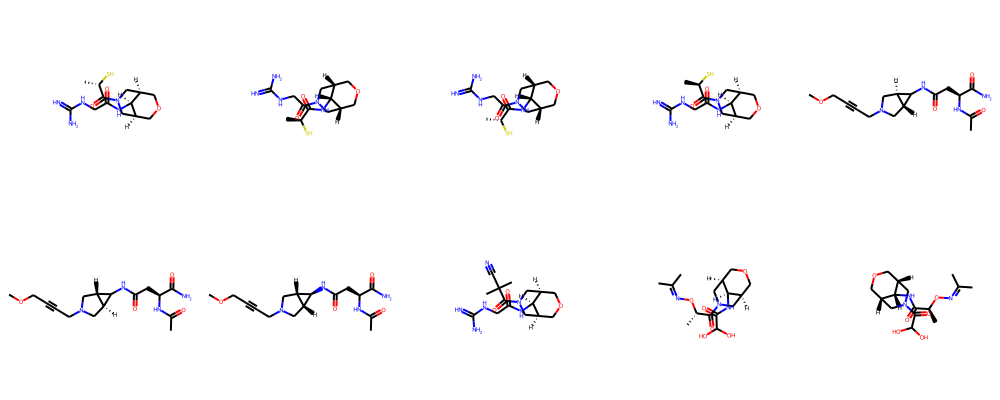

In [13]:
Draw.MolsToGridImage(mols, molsPerRow=5)

# クラスタリング

In [14]:
from rdkit.ML.Cluster import Butina
mols = Chem.SDMolSupplier("ch06_nov_hts.sdf")

In [15]:
len(mols)

385

In [16]:
fps = []
valid_mols = []

for mol in mols:
    if mol is not None:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
        fps.append(fp)
        valid_mols.append(mol)

In [19]:
distance_matrix = []
for i, fp in enumerate(fps):
    distance = DataStructs.BulkTanimotoSimilarity(fps[i], fps[:i+1],returnDistance=True)
    distance_matrix.extend(distance)

In [20]:
clusters = Butina.ClusterData(distance_matrix, len(fps), 0.2, isDistData=True)
len(clusters)

182

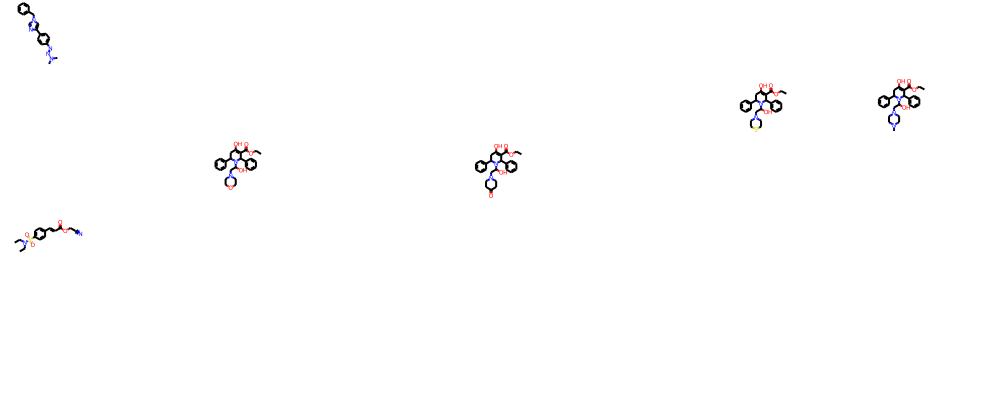

In [21]:
mols_ = [valid_mols[i] for i in clusters[0]]
Draw.MolsToGridImage(mols_, molsPerRow=5)